In [1]:
import pandas as pd

In [2]:
da = pd.read_csv(r"55개채널_전처리완.csv")

In [3]:
da['Comment_Published_At'] = pd.to_datetime(da['Comment_Published_At'])
da['Upload_Date'] = pd.to_datetime(da['Upload_Date'])

In [4]:
# 원래 우리가 임의로 라벨링한 채널들 이름 
k1 = da[da.label==1].Channel_Title.unique()
k2 = da[da.label==0].Channel_Title.unique()

#### 각각의 비디오에 조회수와 댓글로 조화평균값의 구하고 30일로 끊어서 누적 값 데이터 생성

In [5]:
import pandas as pd
import numpy as np

def up_down5_1(Channel_name):
    global da  # 전역 변수 사용 선언
    
    # 필요한 컬럼을 선택
    cd2 = da[['Channel_Title', 'View_Count', 'Video_ID', 'Title', 'Is_Short', 'Comment_Count_12h', 'Upload_Date']]
    
    # 채널명으로 필터링
    one = cd2[cd2['Channel_Title'] == Channel_name].copy()
    
    # 업로드 날짜 기준으로 정렬
    one = one.sort_values(by='Upload_Date').reset_index(drop=True)
    
    # 첫 번째 영상의 업로드 날짜
    first_upload_date = one.iloc[0]['Upload_Date']
    
    # 마지막 영상의 업로드 날짜
    last_upload_date = one.iloc[-1]['Upload_Date']
    
    # 첫 번째 영상 업로드 날짜를 기준으로 한 달 동안의 데이터 필터링
    one_month_later = first_upload_date + pd.DateOffset(months=1)
    one_month_data = one[(one['Upload_Date'] >= first_upload_date) & (one['Upload_Date'] < one_month_later)]
    
    # 첫 달의 조화평균의 합 계산
    total_harmonic_mean = 0
    total_videos = len(one_month_data)  # 첫 달의 영상 수
    
    for idx, row in one_month_data.iterrows():
        view_count = row['View_Count']
        comment_count_12h = row['Comment_Count_12h']
        
        # 조회수를 로그 변환하여 조화 평균 계산
        if view_count > 0 and comment_count_12h > 0:
            view_count_log = np.log(view_count)
            harmonic_mean = 2 / (1 / view_count_log + 1 / comment_count_12h)
        else:
            harmonic_mean = 0  # 조회수나 댓글 수가 0이면 조화 평균을 0으로 설정
        
        total_harmonic_mean += harmonic_mean
    
    # 첫 달의 평균 조화평균 계산
    average_harmonic_mean = total_harmonic_mean / total_videos if total_videos > 0 else 0
    result_data = [{'Channel': Channel_name, 'Year': first_upload_date.year, 'Month': first_upload_date.month, 'Cumulative_Harmonic_Mean': total_harmonic_mean, 'Average_Harmonic_Mean': average_harmonic_mean}]
    
    # 이후 마지막 영상이 올라온 달까지 누적 합 및 평균값 계산 및 데이터 수집
    cumulative_sum = total_harmonic_mean
    cumulative_videos = total_videos
    current_date = one_month_later
    
    while current_date <= last_upload_date:
        next_month = current_date + pd.DateOffset(months=1)
        monthly_data = one[(one['Upload_Date'] >= current_date) & (one['Upload_Date'] < next_month)]
        
        monthly_harmonic_mean = 0
        monthly_videos = len(monthly_data)  # 해당 달의 영상 수
        
        for idx, row in monthly_data.iterrows():
            view_count = row['View_Count']
            comment_count_12h = row['Comment_Count_12h']
            
            if view_count > 0 and comment_count_12h > 0:
                view_count_log = np.log(view_count)
                harmonic_mean = 2 / (1 / view_count_log + 1 / comment_count_12h)
            else:
                harmonic_mean = 0
            
            monthly_harmonic_mean += harmonic_mean
        
        cumulative_sum += monthly_harmonic_mean
        cumulative_videos += monthly_videos
        
        # 해당 달의 평균 조화평균 계산
        average_harmonic_mean = cumulative_sum / cumulative_videos if cumulative_videos > 0 else 0
        
        result_data.append({'Channel': Channel_name, 'Year': current_date.year, 'Month': current_date.month, 'Cumulative_Harmonic_Mean': cumulative_sum, 'Average_Harmonic_Mean': average_harmonic_mean})
        
        current_date = next_month
    
    return pd.DataFrame(result_data)

def aggregate_channel_data(channel_list):
    all_data = pd.DataFrame()
    
    for channel in channel_list:
        channel_data = up_down5_1(channel)
        all_data = pd.concat([all_data, channel_data], ignore_index=True)
    
    return all_data

# 예제 사용
# 채널 리스트 예제
channel_list = da['Channel_Title'].unique()
result_df = aggregate_channel_data(channel_list)
print(result_df)


        Channel  Year  Month  Cumulative_Harmonic_Mean  Average_Harmonic_Mean
0     1분요리 뚝딱이형  2021      6              1.880716e+04               1.705710
1     1분요리 뚝딱이형  2021      7              2.126868e+05               9.156482
2     1분요리 뚝딱이형  2021      8              4.144327e+05              12.821209
3     1분요리 뚝딱이형  2021      9              6.714444e+05              15.227568
4     1분요리 뚝딱이형  2021     10              1.021608e+06              17.356284
...         ...   ...    ...                       ...                    ...
1949       흔한일상  2024      1              5.774221e+06              25.811534
1950       흔한일상  2024      2              5.796476e+06              25.799953
1951       흔한일상  2024      3              5.810579e+06              25.791324
1952       흔한일상  2024      4              5.822957e+06              25.782065
1953       흔한일상  2024      5              5.842608e+06              25.766172

[1954 rows x 5 columns]


In [6]:
result_df[result_df.Channel=='숏박스']

,Channel,Year,Month,Cumulative_Harmonic_Mean,Average_Harmonic_Mean
1275,숏박스,2021,10,1.488143e+05,16.299486
1276,숏박스,2021,11,3.114416e+05,16.676926
1277,숏박스,2021,12,9.544925e+05,23.588100
1278,숏박스,2022,1,1.526210e+06,26.033883
1279,숏박스,2022,2,2.216731e+06,27.582949
1280,숏박스,2022,3,2.686573e+06,28.174730
1281,숏박스,2022,4,3.172319e+06,28.606515
1282,숏박스,2022,5,3.702460e+06,29.029798
1283,숏박스,2022,6,4.273447e+06,29.351402
1284,숏박스,2022,7,4.670500e+06,29.470967


In [7]:
# 'label' 열 추가
result_df['label'] = -1  # 초기값 설정

# '채널 명'에 따라 'label' 값 설정
for i in result_df['Channel'].unique():
    if i in k1:
        result_df.loc[result_df['Channel'] == i, 'label'] = 1
    elif i in k2:
        result_df.loc[result_df['Channel'] == i, 'label'] = 0

In [8]:
# 각 채널의 Year와 Month를 합쳐 period로 변경
def add_period_column(df):
    df = df.sort_values(by=['Channel', 'Year', 'Month']).reset_index(drop=True)
    df['period'] = df.groupby('Channel').cumcount() * 1 + 1
    df.drop(columns=['Year', 'Month'], inplace=True)
    return df

# 변경된 데이터프레임
df = add_period_column(result_df)

In [9]:
# 필요없는 컬럼
df= df.drop('Cumulative_Harmonic_Mean',axis=1)

In [10]:
df[df.Channel=='숏박스']

,Channel,Average_Harmonic_Mean,label,period
1275,숏박스,16.299486,1,1
1276,숏박스,16.676926,1,2
1277,숏박스,23.588100,1,3
1278,숏박스,26.033883,1,4
1279,숏박스,27.582949,1,5
1280,숏박스,28.174730,1,6
1281,숏박스,28.606515,1,7
1282,숏박스,29.029798,1,8
1283,숏박스,29.351402,1,9
1284,숏박스,29.470967,1,10


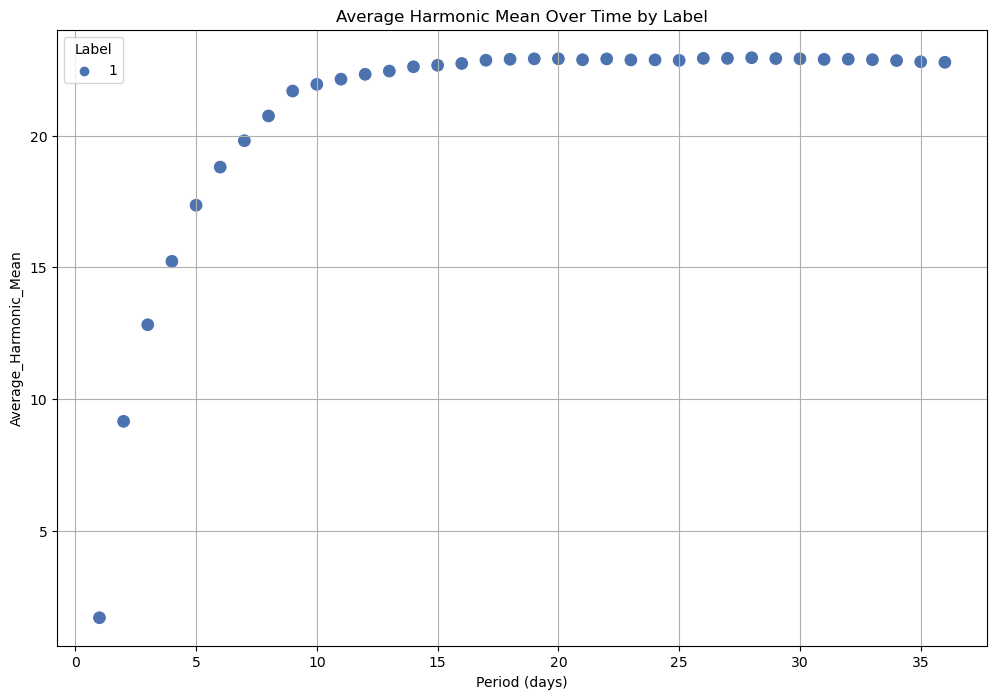

In [11]:
## 증가율로 구한거
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 산점도 그리기
plt.figure(figsize=(12, 8))
sns.scatterplot(data=df[df.Channel=='1분요리 뚝딱이형'], x='period', y='Average_Harmonic_Mean', hue='label', palette='deep', s=100)

plt.title('Average Harmonic Mean Over Time by Label')
plt.xlabel('Period (days)')
plt.ylabel('Average_Harmonic_Mean')
plt.grid(True)
plt.legend(title='Label')
plt.show()

### -----------------------------------------------------------------------------------------------------------------------

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1954 entries, 0 to 1953
Data columns (total 4 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Channel                1954 non-null   object 
 1   Average_Harmonic_Mean  1954 non-null   float64
 2   label                  1954 non-null   int64  
 3   period                 1954 non-null   int64  
dtypes: float64(1), int64(2), object(1)
memory usage: 61.2+ KB


In [13]:
df

,Channel,Average_Harmonic_Mean,label,period
0,1분요리 뚝딱이형,1.705710,1,1
1,1분요리 뚝딱이형,9.156482,1,2
2,1분요리 뚝딱이형,12.821209,1,3
3,1분요리 뚝딱이형,15.227568,1,4
4,1분요리 뚝딱이형,17.356284,1,5
...,...,...,...,...
1949,흔한일상,25.811534,0,57
1950,흔한일상,25.799953,0,58
1951,흔한일상,25.791324,0,59
1952,흔한일상,25.782065,0,60


#### 데이터를 통해 3달동안 가장 많이 값이 증가한 구간을 찾아 첫번째 달과 3번째 달의 기울기를 구함

In [14]:
import pandas as pd
import numpy as np

def calculate_angle(df):
    # 데이터프레임을 복사하고 인덱스를 재설정합니다
    df = df.copy().reset_index(drop=True)
    
    # 데이터프레임의 길이가 3 이하일 경우
    if len(df) <= 3:
        # 첫 번째 값과 마지막 값으로 각도 계산
        first_value = df.loc[0, 'Average_Harmonic_Mean']
        last_value = df.loc[len(df) - 1, 'Average_Harmonic_Mean']
        
        if len(df) == 2:  # 행이 2개일 경우
            first_period = df.loc[0, 'period']
            last_period = df.loc[1, 'period']
        else:  # 행이 3개일 경우
            first_period = df.loc[0, 'period']
            last_period = df.loc[2, 'period']
        
        delta_y = last_value - first_value
        delta_x = last_period - first_period
        
        if delta_x == 0:
            angle = np.nan
        else:
            angle = np.arctan(delta_y / delta_x) * (180 / np.pi)  # 라디안을 도로 변환
        
        # 각 행에 각도 값을 채워 넣기
        df.loc[:, 'Angle'] = angle
        
        return df
    
    # 데이터프레임의 길이가 4 이상인 경우
    # 변화율 계산
    df['Change'] = df['Average_Harmonic_Mean'].diff()
    
    # 연속적인 3개월의 변화율 합계 계산
    df['Three_Month_Sum'] = df['Change'].rolling(window=3).sum()
    
    # 가장 많이 증가한 3개월 구간의 시작 인덱스 찾기
    max_increase_start_idx = df['Three_Month_Sum'].idxmax()
    
    # 유효한 인덱스 범위를 벗어나지 않도록 조정
    max_increase_start_idx = max(0, max_increase_start_idx - 2)
    max_increase_end_idx = min(len(df) - 1, max_increase_start_idx + 2)
    
    # 첫 번째 값과 세 번째 값 사이의 각도 계산
    first_value = df.loc[max_increase_start_idx, 'Average_Harmonic_Mean']
    third_value = df.loc[max_increase_end_idx, 'Average_Harmonic_Mean']
    first_period = df.loc[max_increase_start_idx, 'period']
    third_period = df.loc[max_increase_end_idx, 'period']
    
    delta_y = third_value - first_value
    delta_x = third_period - first_period
    
    if delta_x == 0:
        angle = np.nan
    else:
        angle = np.arctan(delta_y / delta_x) * (180 / np.pi)  # 라디안을 도로 변환
    
    # 각 행에 각도 값을 채워 넣기
    df.loc[:, 'Angle'] = angle
    
    # 변화율과 합계 열 제거
    df = df.drop(columns=['Change', 'Three_Month_Sum'])
    
    return df


In [15]:
calculate_angle(df[df['Channel'] == 'asmr soupe'])

,Channel,Average_Harmonic_Mean,label,period,Angle
0,asmr soupe,0.000000,0,1,56.6725
1,asmr soupe,0.000000,0,2,56.6725
2,asmr soupe,0.000000,0,3,56.6725
3,asmr soupe,0.000000,0,4,56.6725
4,asmr soupe,0.000000,0,5,56.6725
...,...,...,...,...,...
106,asmr soupe,23.039055,0,107,56.6725
107,asmr soupe,23.017229,0,108,56.6725
108,asmr soupe,23.006087,0,109,56.6725
109,asmr soupe,22.998658,0,110,56.6725


In [16]:
calculate_angle(df[df['Channel'] == '비치키'])

,Channel,Average_Harmonic_Mean,label,period,Angle
0,비치키,4.081274,1,1,71.808399
1,비치키,3.833733,1,2,71.808399
2,비치키,3.833733,1,3,71.808399
3,비치키,3.168868,1,4,71.808399
4,비치키,3.213908,1,5,71.808399
5,비치키,1.970301,1,6,71.808399
6,비치키,4.108965,1,7,71.808399
7,비치키,4.301428,1,8,71.808399
8,비치키,5.063910,1,9,71.808399
9,비치키,5.833479,1,10,71.808399


In [17]:
k = df.Channel.unique()

In [18]:
k

array(['1분요리 뚝딱이형', 'DDany Crafts 따니네 만들기', 'Dust House', 'HAHNS ATELIER',
       'NamCook 남쿡', 'Orosina 오로시나', 'PixShort', 'Simple is Magic',
       "Sophie's Magic Diary", 'Tigger ASMR', 'asmr soupe', '가든의 세계여행',
       '곽튜브', '긱블 Geekble', '꿀주부 Honeyjubu', '꿈나무의 100억 부자 챌린지', '난두팔',
       '너덜트', '뉴욕밥상 New York Cooking Table', '다해', '도시오리 CityDuck',
       '동네 의사 이상욱', '띱 Deep', '먹어볼래TryToEat', '못생긴 노을이',
       '봄날언니 정혜영 [Bomnal Unnie]', '브레이너 제이의 숙면 여행', '비치키', '빨간내복야코',
       '빵과쏭', '빵빵이의 일상', '살림팝', '생활건강정보-구구팔팔', '셜록뷰티 - 아름다움은 과학이다', '숏박스',
       '술익는집', '스토리', '아빠와 고양이 Dad and Cats', '아이템의 인벤토리',
       '언더월드 UNDER WORLD', '옌마드Yenmad', '요리하는다이어터', '유지만 yuziman', '이비온',
       '이상한리뷰의앨리스 Alice in WonderReview', '인생 녹음 중', '자세요정 JSYJ',
       '제이나 [Jaina]', '지뻔뻔', '지식은 날리지 [Jisik is Knowledge]', '지식코리야',
       '크림서현', '팩토리', '페퍼찐 PAPER JJIN', '흔한일상'], dtype=object)

### 각각의 채널마다 데이터프레임 만든 것을 하나의 데이터프레임으로 결합

In [19]:
import pandas as pd

dataframes = []
for i in k:
    # 각 채널별로 계산된 데이터프레임을 리스트에 추가
    result_df = calculate_angle(df[df['Channel'] == i])
    dataframes.append(result_df)

# 데이터프레임 리스트를 하나의 데이터프레임으로 결합
combined_df = pd.concat(dataframes, ignore_index=True)

# 결과 출력
print("모든 데이터를 합쳤습니다.")

모든 데이터를 합쳤습니다.


In [22]:
combined_df.to_csv(r"가공데이터_조건.csv",index=False)

In [23]:
combined_df

,Channel,Average_Harmonic_Mean,label,period,Angle
0,1분요리 뚝딱이형,1.705710,1,1,71.766547
1,1분요리 뚝딱이형,9.156482,1,2,71.766547
2,1분요리 뚝딱이형,12.821209,1,3,71.766547
3,1분요리 뚝딱이형,15.227568,1,4,71.766547
4,1분요리 뚝딱이형,17.356284,1,5,71.766547
...,...,...,...,...,...
1949,흔한일상,25.811534,0,57,4.420959
1950,흔한일상,25.799953,0,58,4.420959
1951,흔한일상,25.791324,0,59,4.420959
1952,흔한일상,25.782065,0,60,4.420959
